#**Kim CNN**

Vinayak Gupta, 21st May 2021

I have implemented the KimCNN model. This architecture basically uses CNN for NLP. We try to stack the embedded word vectors to form a matrix and on that we apply the convolution operation.

**Kim CNN** 

The information which I am sharing is mostly from this paper. So if you want a very good understanding of the model, you can have a look at the paper [link text](https://arxiv.org/pdf/1408.5882.pdf)

**Dataset Download** 

The dataset is from a Kaggle competition called Quora Insincere Questions Classification. You can download the dataset from the link [link text](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
import torch

import pandas as pd
import numpy as np
!pip install pyprind
import random
import os
import torch
import torch.nn as nn

import torch.nn as nn
import torch.nn.functional as F


import os
import spacy
import nltk
import torchtext
import matplotlib.pyplot as plt 
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**Text Classification**

In [ ]:
PATH = '/content/drive/MyDrive/Quora Insincere Dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading the Dataset

**Field**</br> 
- Defines a datatype together with instructions for converting to Tensor.
- It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations.
- The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

**Label Field**</br>
- A shallow wrapper around a standard field designed to hold labels for a classification task.

**Tokenizer**</br>
- During processing, _spaCy_ first tokenizes the text, i.e. segments it into words, punctuation and so on. This is done by applying rules specific to each language.

- ![Tokenizer](https://spacy.io/tokenization-9b27c0f6fe98dcb26239eba4d3ba1f3d.svg)

**Bulid Vocab**</br>
- Construct the Vocab object for this field from the dataset which occurs with a minimum frequency.
- Converts and Stores the numerical representations of the vocabulary using the pre trained weights.

**Pretrained Weights: [Glove Embeddings](https://nlp.stanford.edu/projects/glove/)**</br>
- Training is performed on aggregated global word-word co-occurrence statistics from a corpus.
- The resulting representations showcase interesting linear substructures of the word vector space.
    * The Euclidean distance between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words.



**Bucket Iterator**</br>
- Defines an iterator that batches examples of similar lengths together.
- Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.


In [ ]:
import torch
import os
import spacy
import nltk
import torchtext

class CreateDataset(torch.utils.data.Dataset):

    def __init__(self, PATH, batch_size=32):
        self.PATH = PATH
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.spacy = spacy.load("en_core_web_sm")

        self.TEXT = torchtext.legacy.data.Field(sequential=True, tokenize="spacy")
        self.LABEL = torchtext.legacy.data.LabelField(dtype=torch.long, sequential=False)

        self.initData()
        self.initEmbed()

        self.makeData()

    def initData(self):
        DATA = os.path.join(self.PATH, 'inputs/')

        self.train_data, self.valid_data, self.test_data = torchtext.legacy.data.TabularDataset.splits(
                        path=DATA, 
                        train="train.csv", validation="valid.csv", test="test.csv", 
                        format="csv", 
                        skip_header=True, 
                        fields=[('Text', self.TEXT), ('Label', self.LABEL)])

    def initEmbed(self):
        EMBED = os.path.join(self.PATH, "embeddings/glove.840B.300d/glove.840B.300d.txt")

        self.TEXT.build_vocab(self.train_data,
                         vectors=torchtext.vocab.Vectors(EMBED), 
                         max_size=20000, 
                         min_freq=10)
        self.LABEL.build_vocab(self.train_data)

    def makeData(self):
        self.train_iterator, self.valid_iterator, self.test_iterator = torchtext.legacy.data.BucketIterator.splits(
                        (self.train_data, self.valid_data, self.test_data), 
                        sort_key=lambda x: len(x.Text), 
                        batch_size=self.batch_size,
                        device=self.device)

    def lengthData(self):
        return len(self.train_data), len(self.valid_data), len(self.test_data)
    
    def lengthVocab(self):
        return len(self.TEXT.vocab), len(self.LABEL.vocab)

    def freqLABEL(self):
        return self.LABEL.vocab.freqs

    def getData(self):
        return self.train_iterator, self.valid_iterator, self.test_iterator

    def getEmbeddings(self):
        return self.TEXT.vocab.vectors

# Data Preprocessing

Ensuring unbiased split of dataset by distributing the classes equally.

**Saving the preprocessed dataset**


To avoid multiple computations.

In [ ]:
main_df = pd.read_csv(os.path.join('/content/drive/MyDrive/Quora Insincere Dataset/train.csv'))
main_df = main_df.sample(n=main_df.shape[0])
main_df = main_df[["question_text", "target"]]
main_df.head()

o_class = main_df.loc[main_df.target == 0, :]
l_class = main_df.loc[main_df.target == 1, :]

test_o = o_class.iloc[:1000, :]
test_l = l_class.iloc[:1000, :]
valid_o = o_class.iloc[1000:2000, :]
valid_l = l_class.iloc[1000:2000, :]
train_o = o_class.iloc[2000:20000, :]
train_l = l_class.iloc[2000:20000, :]

train = pd.concat([train_o, train_l], axis=0)
print(train.shape)
valid = pd.concat([valid_o, valid_l], axis=0)
print(valid.shape)
test = pd.concat([test_o, test_l], axis=0)
print(test.shape)

!mkdir inputs
input_path = '/content'
train.to_csv(os.path.join(input_path, "inputs/train.csv"), index=False)
test.to_csv(os.path.join(input_path, "inputs/test.csv"), index=False)
valid.to_csv(os.path.join(input_path, "inputs/valid.csv"), index=False)
del main_df, train, test, valid, train_l, train_o, test_l, test_o, valid_l,valid_o, o_class, l_class

dataset = CreateDataset(input_path)
train_iterator, valid_iterator, test_iterator = dataset.getData()

(36000, 2)
(2000, 2)
(2000, 2)
mkdir: cannot create directory ‘inputs’: File exists


#**Model Architecture**

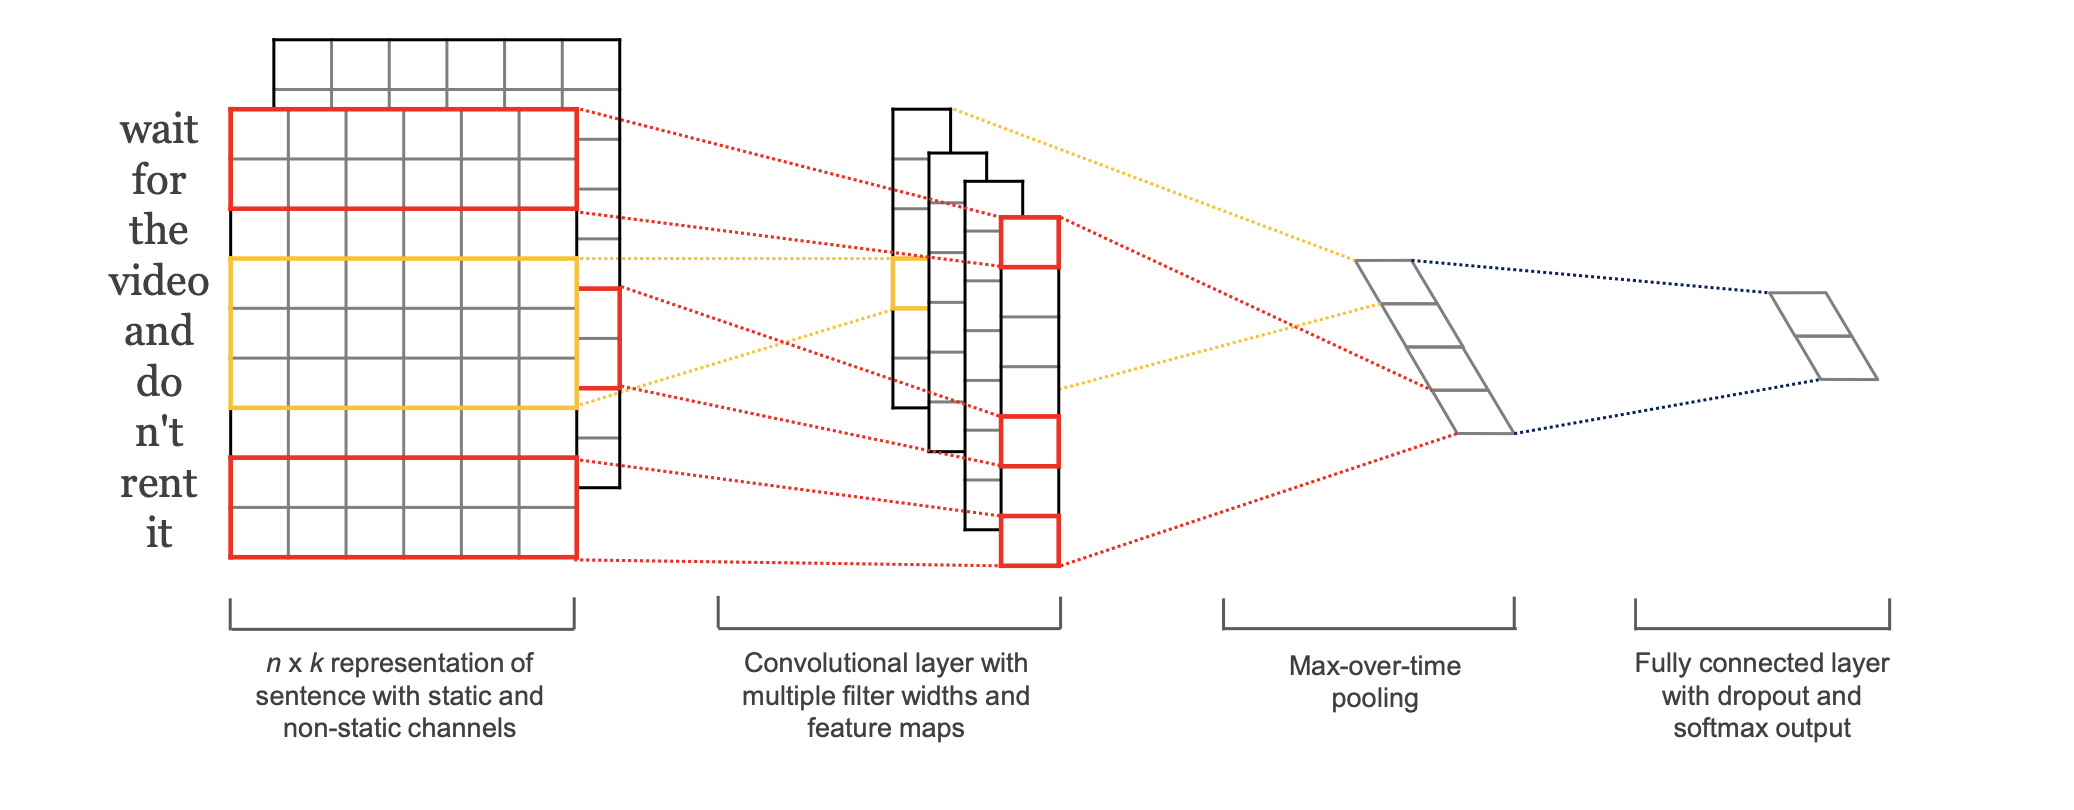

We use CNNs in NLP(Text Classification). This model outperforms many state of the art models. The above diagram is a clear picture of how the model works. We stack the words in a row fashion and then we apply convolution to this Matrix. We choose many different filter sizes. In our case we use 3 filters with filter sizes 3,4 and 5. You can increase the number of filters used to get more accurate results. After the convolution step, we apply max-pool on the output obtained from the convolution step. So now we concatenate all the outputs to get a single vector. We apply a fully connected layer to this vector and the output is a single value 0 or 1.



In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # nn.ModuleList is like a register which stores all the different convolutions

        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [text len, batch size]

        text = torch.reshape(text, (-1, text.shape[0]))

        #text = [batch size, text len]

        embedded = self.embedding(text)   

        #embedded = [batch size, text len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, text len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, text len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        out = self.fc(cat)

        return out

We are loading the pretrained_embeddings into the model. 

PAD_IDX = dataset.TEXT.vocab.stoi[dataset.TEXT.pad_token] basically finds the index of the pad token in the word embedding so that it can set that to zero in the nn.Embedding step. 

In [ ]:
pretrained_embeddings = dataset.getEmbeddings()
INPUT_DIM = dataset.lengthVocab()[0]
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.2
PAD_IDX = dataset.TEXT.vocab.stoi[dataset.TEXT.pad_token]
model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model.embedding.weight.data = pretrained_embeddings.to(device)
model = model.to(device)

UNK_IDX is the index of the unknown token. In this case it is actually equal to zero. We are setting those words which are either not in our dictionary or padded words to zero vectors of size of the embedding_dim

In [ ]:
UNK_IDX = dataset.TEXT.vocab.stoi[dataset.TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
epoch_train_losses = []              # Defining an empty list to store the epoch losses
epoch_test_losses = []
epoch_val_losses = []              # Defining an empty list to store the epoch losses
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

#**Training and Evaluation**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.001)

criterion = nn.BCEWithLogitsLoss()

criterion = criterion.to(device)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    train_loss_batch = []
    accu_train_batch = []
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        predictions = model(batch.Text).squeeze(1)
        batch.Label = (batch.Label).type_as(predictions)
        
        train_loss = criterion(predictions, batch.Label)
        acc = binary_accuracy(predictions, batch.Label)
        
        train_loss.backward()
        optimizer.step()
        
        train_loss_batch.append(train_loss)
        accu_train_batch.append(acc)
        
    epoch_train_losses.append(sum(train_loss_batch)/len(iterator))
    accu_train_epoch.append(sum(accu_train_batch)/len(iterator))

    return epoch_train_losses[-1], accu_train_epoch[-1]

def evaluate(model, iterator, criterion):
    
    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Text).squeeze(1)
            batch.Label = (batch.Label).type_as(predictions)
            val_loss = criterion(predictions, batch.Label)
            
            acc = binary_accuracy(predictions, batch.Label)

            val_loss_batch.append(val_loss)
            accu_val_batch.append(acc)

        epoch_val_losses.append(sum(val_loss_batch)/len(iterator))
        accu_val_epoch.append(sum(accu_val_batch)/len(iterator))
    return epoch_val_losses[-1], accu_val_epoch[-1]

In [ ]:
epochs = 200

for epoch in range(epochs):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

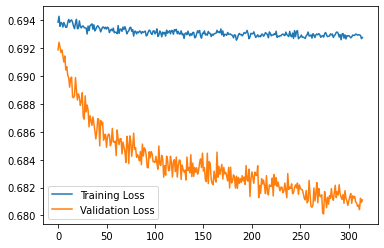

In [ ]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.legend()
plt.show()

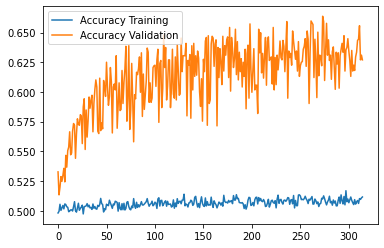

In [ ]:
plt.plot(accu_train_epoch, label='Accuracy Training')
plt.plot(accu_val_epoch, label='Accuracy Validation')
plt.legend()
plt.show()

#**Texting**

Here you can type in any sentence and the trained model will give you whether the sentence is good or bad

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence, min_len = 3):
    #sentence = torch.reshape(sentence, (-1, sentence.shape[0]))
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [dataset.TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    tensor = torch.reshape(tensor, (-1, tensor.shape[0]))
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

predict_sentiment(model, "Happy best boy in the world")